# Install MuJoCo, MJX, and Brax

In [1]:
# !pip install mujoco
# !pip install mujoco_mjx
# !pip install brax

In [3]:
#@title Import packages for plotting and creating graphics
import time
import itertools
import numpy as np
from typing import Callable, NamedTuple, Optional, Union, List

# Graphics and plotting.
# print('Installing mediapy:')
# !command -v ffmpeg >/dev/null || (apt update && apt install -y ffmpeg)
# !pip install -q mediapy
import mediapy as media
# import matplotlib.pyplot as plt

# More legible printing from numpy.
np.set_printoptions(precision=3, suppress=True, linewidth=100)

In [4]:
#@title Import MuJoCo, MJX, and Brax


from datetime import datetime
import functools
from IPython.display import HTML
import jax
from jax import numpy as jp
import numpy as np
from typing import Any, Dict, Sequence, Tuple, Union

from brax import base
from brax import envs
from brax import math
from brax.base import Base, Motion, Transform
from brax.envs.base import Env, PipelineEnv, State
from brax.mjx.base import State as MjxState
from brax.training.agents.ppo import train as ppo
from brax.training.agents.ppo import networks as ppo_networks
from brax.io import html, mjcf, model

from etils import epath
from flax import struct
from matplotlib import pyplot as plt
import mediapy as media
from ml_collections import config_dict
import mujoco
from mujoco import mjx

import mujoco_py

# Introduction to MJX

MJX is an implementation of MuJoCo written in [JAX](https://jax.readthedocs.io/en/latest/index.html), enabling large batch training on GPU/TPU. In this notebook, we will demonstrate how to train RL policies with MJX.

Before we get into hefty RL workloads, let's get started with a simpler example! The entrypoint into MJX is through MuJoCo, so first we load a MuJoCo model:

In [5]:
xml = """
<mujoco>
  <worldbody>
    <light name="top" pos="0 0 1"/>
    <body name="box_and_sphere" euler="0 0 -30">
      <joint name="swing" type="hinge" axis="1 -1 0" pos="-.2 -.2 -.2"/>
      <geom name="red_box" type="box" size=".2 .2 .2" rgba="1 0 0 1"/>
      <geom name="green_sphere" pos=".2 .2 .2" size=".1" rgba="0 1 0 1"/>
    </body>
  </worldbody>
</mujoco>
"""

# Make model, data, and renderer
mj_model = mujoco.MjModel.from_xml_string(xml)
mj_data = mujoco.MjData(mj_model)
renderer = mujoco.Renderer(mj_model)

Next we take the MuJoCo model and data, and place them on the GPU device using MJX.

In [6]:
mjx_model = mjx.put_model(mj_model)
mjx_data = mjx.put_data(mj_model, mj_data)

Below, we print the `qpos` from MuJoCo and MJX. Notice that the `qpos` for the mjData is a numpy array living on the CPU, while the `qpos` for `mjx.Data` is a JAX Array living on the GPU device.

In [7]:
print(mj_data.qpos, type(mj_data.qpos))
print(mjx_data.qpos, type(mjx_data.qpos), mjx_data.qpos.devices())

[0.] <class 'numpy.ndarray'>
[0.] <class 'jaxlib.xla_extension.ArrayImpl'> {cuda(id=0)}


Let's run the simulation in MuJoCo and render the trajectory. This example is taken from the [MuJoCo tutorial](https://colab.sandbox.google.com/github/google-deepmind/mujoco/blob/main/python/tutorial.ipynb).

In [8]:
# enable joint visualization option:
scene_option = mujoco.MjvOption()
scene_option.flags[mujoco.mjtVisFlag.mjVIS_JOINT] = True

duration = 3.8  # (seconds)
framerate = 60  # (Hz)

frames = []
mujoco.mj_resetData(mj_model, mj_data)
while mj_data.time < duration:
  mujoco.mj_step(mj_model, mj_data)
  if len(frames) < mj_data.time * framerate:
    renderer.update_scene(mj_data, scene_option=scene_option)
    pixels = renderer.render()
    frames.append(pixels)

# Simulate and display video.
media.show_video(frames, fps=framerate)

Now let's run the same exact simulation on the GPU device using MJX!

In the example below, we use `mjx.step` instead of `mujoco.mj_step`, and we also [`jax.jit`](https://jax.readthedocs.io/en/latest/jax-101/02-jitting.html) the `mjx.step` so that it runs efficiently on the GPU. After each step, we convert the `mjx.Data` back to `mjData` so that we can use the MuJoCo renderer.


In [9]:

jit_step = jax.jit(mjx.step)

frames = []
mujoco.mj_resetData(mj_model, mj_data)
mjx_data = mjx.put_data(mj_model, mj_data)
while mjx_data.time < duration:
  mjx_data = jit_step(mjx_model, mjx_data)
  if len(frames) < mjx_data.time * framerate:
    mj_data = mjx.get_data(mj_model, mjx_data)
    renderer.update_scene(mj_data, scene_option=scene_option)
    pixels = renderer.render()
    frames.append(pixels)

media.show_video(frames, fps=framerate)

2024-05-02 18:24:04.682584: W external/xla/xla/service/gpu/nvptx_compiler.cc:718] The NVIDIA driver's CUDA version is 12.2 which is older than the ptxas CUDA version (12.4.131). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


Running single threaded physics simulation on the GPU is not very [efficient](https://mujoco.readthedocs.io/en/stable/mjx.html#mjx-the-sharp-bits). The advantage with MJX is that we can run environments in parallel on a hardware accelerated device. Let's try it out!

In the example below, we create 4096 copies of the `mjx.Data` and we run the `mjx.step` over the batched data. Since MJX is implemented in JAX, we take advantage of [`jax.vmap`](https://jax.readthedocs.io/en/latest/_autosummary/jax.vmap.html) to run the `mjx.step` in parallel over all `mjx.Data`.

In [10]:
rng = jax.random.PRNGKey(0)
rng = jax.random.split(rng, 4096)
batch = jax.vmap(lambda rng: mjx_data.replace(qpos=jax.random.uniform(rng, (1,))))(rng)

jit_step = jax.jit(jax.vmap(mjx.step, in_axes=(None, 0)))
batch = jit_step(mjx_model, batch)

print(batch.qpos)

[[0.625]
 [0.091]
 [0.678]
 ...
 [0.033]
 [0.213]
 [0.81 ]]


We can copy the batched `mjx.Data` back to MuJoCo like we did before:

In [11]:
batched_mj_data = mjx.get_data(mj_model, batch)
print([d.qpos for d in batched_mj_data])

[array([0.625]), array([0.091]), array([0.678]), array([0.174]), array([0.047]), array([0.255]), array([0.88]), array([0.839]), array([0.074]), array([0.698]), array([0.769]), array([0.453]), array([0.593]), array([0.962]), array([0.749]), array([0.71]), array([0.956]), array([0.999]), array([0.731]), array([0.852]), array([0.31]), array([0.07]), array([0.813]), array([0.995]), array([0.108]), array([0.155]), array([0.42]), array([0.441]), array([0.917]), array([0.18]), array([0.551]), array([0.914]), array([0.289]), array([0.973]), array([0.737]), array([0.408]), array([0.077]), array([0.572]), array([0.545]), array([0.538]), array([0.66]), array([0.97]), array([0.33]), array([0.728]), array([0.482]), array([0.213]), array([0.784]), array([0.522]), array([0.709]), array([0.695]), array([0.432]), array([0.52]), array([0.568]), array([0.895]), array([0.382]), array([0.636]), array([0.305]), array([0.329]), array([0.443]), array([0.328]), array([0.372]), array([0.816]), array([0.824]), a

# Training a Policy with MJX

Running large batch physics simulation is useful for training RL policies. Here we demonstrate training RL policies with MJX using the RL library from [Brax](https://github.com/google/brax).

Below, we implement the classic Humanoid environment using MJX and Brax. We inherit from the `MjxEnv` implementation in Brax so that we can step the physics with MJX while training with Brax RL implementations.


In [12]:
#@title Humanoid Env

class Humanoid(PipelineEnv):

  def __init__(
      self,
      forward_reward_weight=1.25,
      ctrl_cost_weight=0.1,
      healthy_reward=5.0,
      terminate_when_unhealthy=True,
      healthy_z_range=(1.0, 2.0),
      reset_noise_scale=1e-2,
      exclude_current_positions_from_observation=True,
      **kwargs,
  ):
    path = epath.Path(epath.resource_path('mujoco')) / (
        'mjx/test_data/humanoid'
    )
    print(path)
    mj_model = mujoco.MjModel.from_xml_path(
        (path / 'stompy.xml').as_posix())
    mj_model.opt.solver = mujoco.mjtSolver.mjSOL_CG
    mj_model.opt.iterations = 6
    mj_model.opt.ls_iterations = 6

    sys = mjcf.load_model(mj_model)

    physics_steps_per_control_step = 5
    kwargs['n_frames'] = kwargs.get(
        'n_frames', physics_steps_per_control_step)
    kwargs['backend'] = 'mjx'

    super().__init__(sys, **kwargs)

    self._forward_reward_weight = forward_reward_weight
    self._ctrl_cost_weight = ctrl_cost_weight
    self._healthy_reward = healthy_reward
    self._terminate_when_unhealthy = terminate_when_unhealthy
    self._healthy_z_range = healthy_z_range
    self._reset_noise_scale = reset_noise_scale
    self._exclude_current_positions_from_observation = (
        exclude_current_positions_from_observation
    )

  def reset(self, rng: jp.ndarray) -> State:
    """Resets the environment to an initial state."""
    rng, rng1, rng2 = jax.random.split(rng, 3)

    low, hi = -self._reset_noise_scale, self._reset_noise_scale
    qpos = self.sys.qpos0 + jax.random.uniform(
        rng1, (self.sys.nq,), minval=low, maxval=hi
    )
    qvel = jax.random.uniform(
        rng2, (self.sys.nv,), minval=low, maxval=hi
    )

    data = self.pipeline_init(qpos, qvel)

    obs = self._get_obs(data, jp.zeros(self.sys.nu))
    reward, done, zero = jp.zeros(3)
    metrics = {
        'forward_reward': zero,
        'reward_linvel': zero,
        'reward_quadctrl': zero,
        'reward_alive': zero,
        'x_position': zero,
        'y_position': zero,
        'distance_from_origin': zero,
        'x_velocity': zero,
        'y_velocity': zero,
    }
    return State(data, obs, reward, done, metrics)

  def step(self, state: State, action: jp.ndarray) -> State:
    """Runs one timestep of the environment's dynamics."""
    data0 = state.pipeline_state
    data = self.pipeline_step(data0, action)

    com_before = data0.subtree_com[1]
    com_after = data.subtree_com[1]
    velocity = (com_after - com_before) / self.dt
    forward_reward = self._forward_reward_weight * velocity[0]

    min_z, max_z = self._healthy_z_range
    is_healthy = jp.where(data.q[2] < min_z, 0.0, 1.0)
    is_healthy = jp.where(data.q[2] > max_z, 0.0, is_healthy)
    if self._terminate_when_unhealthy:
      healthy_reward = self._healthy_reward
    else:
      healthy_reward = self._healthy_reward * is_healthy

    ctrl_cost = self._ctrl_cost_weight * jp.sum(jp.square(action))

    obs = self._get_obs(data, action)
    reward = forward_reward + healthy_reward - ctrl_cost
    done = 1.0 - is_healthy if self._terminate_when_unhealthy else 0.0
    state.metrics.update(
        forward_reward=forward_reward,
        reward_linvel=forward_reward,
        reward_quadctrl=-ctrl_cost,
        reward_alive=healthy_reward,
        x_position=com_after[0],
        y_position=com_after[1],
        distance_from_origin=jp.linalg.norm(com_after),
        x_velocity=velocity[0],
        y_velocity=velocity[1],
    )

    return state.replace(
        pipeline_state=data, obs=obs, reward=reward, done=done
    )

  def _get_obs(
      self, data: mjx.Data, action: jp.ndarray
  ) -> jp.ndarray:
    """Observes humanoid body position, velocities, and angles."""
    position = data.qpos
    if self._exclude_current_positions_from_observation:
      position = position[2:]

    # external_contact_forces are excluded
    return jp.concatenate([
        position,
        data.qvel,
        data.cinert[1:].ravel(),
        data.cvel[1:].ravel(),
        data.qfrc_actuator,
    ])


envs.register_environment('humanoid', Humanoid)

## Visualize a Rollout

Let's instantiate the environment and visualize a short rollout.

NOTE: Since episodes terminates early if the torso is below the healthy z-range, the only relevant contacts for this task are between the feet and the plane. We turn off other contacts.

In [13]:
# instantiate the environment
env_name = 'humanoid'
env = envs.get_environment(env_name)

# define the jit reset/step functions
jit_reset = jax.jit(env.reset)
jit_step = jax.jit(env.step)


/home/zahir/.local/lib/python3.10/site-packages/mujoco/mjx/test_data/humanoid


/home/zahir/.local/lib/python3.10/site-packages/mujoco/mjx/_src/mesh.py:207: UserWarning: Mesh "legs_1_right_leg_1_foot_1" has a coplanar face with more than 20 vertices. This may lead to performance issues and inaccuracies in collision detection. Consider decimating the mesh.
  warnings.warn(


In [14]:
# initialize the state
state = jit_reset(jax.random.PRNGKey(0))
rollout = [state.pipeline_state]



# create MuJoCo visualization
# mj_viewer = mujoco_py.MjViewer()
# mj_viewer.start()

# grab a trajectory
for i in range(10):
  ctrl = -0.1 * jp.ones(env.sys.nu)
  state = jit_step(state, ctrl)
  rollout.append(state.pipeline_state)
  
  # Update MuJoCo visualization
  # mj_viewer.render()
# env.render(rollout, camera='side')



In [15]:
media.show_video(env.render(rollout, camera='side'), fps=1.0 / env.dt)

## Train Humanoid Policy

Let's now train a policy with PPO to make the Humanoid run forwards. Training takes about 6 minutes on a Tesla A100 GPU.

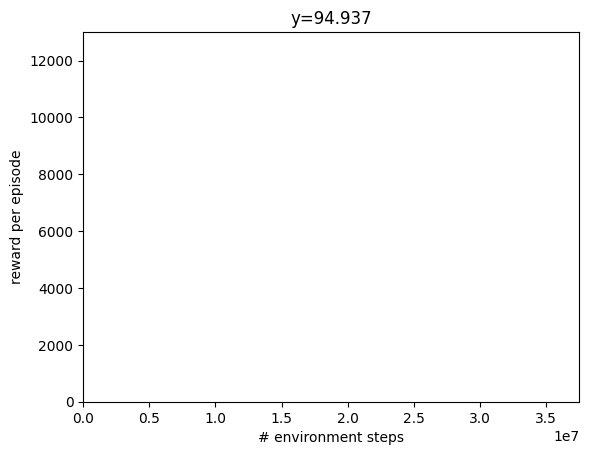

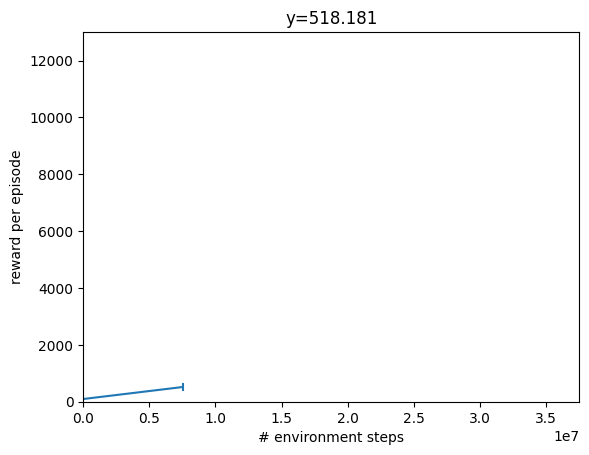

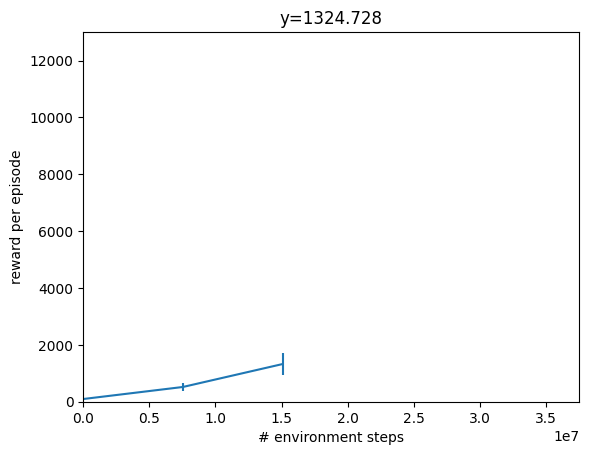

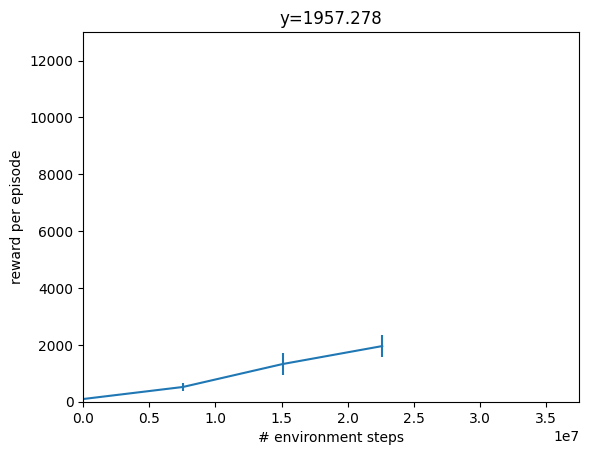

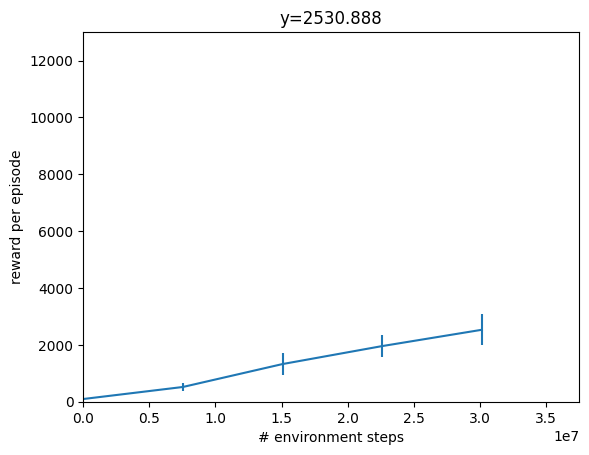

time to jit: 0:01:22.682508
time to train: 0:18:35.257340


In [16]:
train_fn = functools.partial(
    ppo.train, num_timesteps=30_000_000, num_evals=5, reward_scaling=0.1,
    episode_length=1000, normalize_observations=True, action_repeat=1,
    unroll_length=10, num_minibatches=32, num_updates_per_batch=8,
    discounting=0.97, learning_rate=3e-4, entropy_cost=1e-3, num_envs=2048,
    batch_size=1024, seed=0)


x_data = []
y_data = []
ydataerr = []
times = [datetime.now()]

max_y, min_y = 13000, 0
def progress(num_steps, metrics):
  times.append(datetime.now())
  x_data.append(num_steps)
  y_data.append(metrics['eval/episode_reward'])
  ydataerr.append(metrics['eval/episode_reward_std'])

  plt.xlim([0, train_fn.keywords['num_timesteps'] * 1.25])
  plt.ylim([min_y, max_y])

  plt.xlabel('# environment steps')
  plt.ylabel('reward per episode')
  plt.title(f'y={y_data[-1]:.3f}')

  plt.errorbar(
      x_data, y_data, yerr=ydataerr)
  plt.show()

make_inference_fn, params, _= train_fn(environment=env, progress_fn=progress)

print(f'time to jit: {times[1] - times[0]}')
print(f'time to train: {times[-1] - times[1]}')

<!-- ## Save and Load Policy -->

We can save and load the policy using the brax model API.

In [17]:
#@title Save Model
model_path = 'mjx_brax_policy'
model.save_params(model_path, params)

In [18]:
#@title Load Model and Define Inference Function
params = model.load_params(model_path)

inference_fn = make_inference_fn(params)
jit_inference_fn = jax.jit(inference_fn)

 Visualize Policy

Finally we can visualize the policy.

In [30]:
eval_env = envs.get_environment(env_name)

jit_reset = jax.jit(eval_env.reset)
jit_step = jax.jit(eval_env.step)

/home/zahir/.local/lib/python3.10/site-packages/mujoco/mjx/test_data/humanoid


In [27]:
# initialize the state
rng = jax.random.PRNGKey(0)
state = jit_reset(rng)
rollout = [state.pipeline_state]

# grab a trajectory
n_steps = 500
render_every = 2

for i in range(n_steps):
  act_rng, rng = jax.random.split(rng)
  ctrl, _ = jit_inference_fn(state.obs, act_rng)
  state = jit_step(state, ctrl)
  rollout.append(state.pipeline_state)

  if state.done:
    break

# media.show_video(env.render(rollout[::render_every], camera='side'), fps=1.0 / env.dt / render_every)

In [ ]:
media.show_video(env.render(rollout[::render_every], camera='side'), fps=1.0 / env.dt / render_every)